In [1]:
import os
import datetime
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection, metrics
import copy

/home/fraz/anaconda3/envs/mlenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
local_path = 'data/clustering/'

path = local_path

# For test train files
df = pd.read_csv(path+'pokedex_(Update_05.20).csv',  index_col=0)

In [4]:
# Checking for non numeric data

non_numeric_columns = list(df.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['name', 'german_name', 'japanese_name', 'status', 'species', 'type_1', 'type_2', 'ability_1', 'ability_2', 'ability_hidden', 'growth_rate', 'egg_type_1', 'egg_type_2']


In [5]:
df.describe().style.background_gradient(cmap="Pastel1")

,pokedex_number,generation,type_number,height_m,weight_kg,abilities_number,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,base_experience,egg_type_number,percentage_male,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fight,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
count,1028.000000,1028.000000,1028.000000,1028.000000,1027.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,924.000000,924.000000,924.000000,1028.000000,792.000000,1027.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,437.711089,4.034047,1.527237,1.368093,69.753749,2.284047,437.571984,69.577821,80.119650,74.475681,72.732490,72.132296,68.534047,93.172078,64.139610,153.814935,1.271401,55.003157,30.316456,0.868434,1.125486,1.053502,1.034290,1.004134,1.196498,1.078794,0.952335,1.084630,1.166342,0.979329,0.992461,1.239786,1.010700,0.975681,1.065661,0.980302,1.084874
std,259.366480,2.234937,0.499501,3.380126,129.221230,0.794981,121.664910,26.385849,32.372321,31.303309,32.677698,28.083684,29.802103,75.240630,21.455464,79.270628,0.451417,20.182675,28.942912,0.286236,0.717742,0.613411,0.645167,0.748527,0.759471,0.754969,0.542982,0.784937,0.593030,0.499146,0.598301,0.699156,0.558533,0.377549,0.451054,0.503434,0.527743
min,1.000000,1.000000,1.000000,0.100000,0.100000,0.000000,175.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,3.000000,0.000000,36.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000
25%,213.750000,2.000000,1.000000,0.600000,8.800000,2.000000,330.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,45.000000,70.000000,67.000000,1.000000,50.000000,20.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000
50%,433.500000,4.000000,2.000000,1.000000,28.500000,2.000000,455.000000,66.500000,76.000000,70.000000,65.000000,70.000000,65.000000,60.000000,70.000000,159.000000,1.000000,50.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,663.250000,6.000000,2.000000,1.500000,69.100000,3.000000,510.000000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,127.000000,70.000000,201.500000,2.000000,50.000000,25.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.625000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,890.000000,8.000000,2.000000,100.000000,999.900000,3.000000,1125.000000,255.000000,190.000000,250.000000,194.000000,250.000000,180.000000,255.000000,140.000000,608.000000,2.000000,100.000000,120.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000


In [6]:
# Can any floats be ints?
(df[shouldbenumbers] % 1  == 0).all() # None
couldbeints
(indicatorsdf[couldbeints].fillna(-9999) % 1  == 0).all()

NameError: name 'shouldbenumbers' is not defined

In [7]:
# Mem reduction function by converting data types. (Credit to Guillaume Martin and Arjan Groen)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)  
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return
reduce_mem_usage(df)

Mem. usage decreased to  0.18 Mb (55.4% reduction)


In [8]:
def downcastMemoryUsage(dataFrame):
    startMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is: \033[1m{:.2f} MB\033[0m'.format(startMemoryOptimization))
    subTypeInt = ['uint8','uint16','uint32','uint64','int8','int16','int32','int64']
    subTypeFloat = ['float16','float32','float64']
    for column in dataFrame.columns:
        columnType = str(dataFrame[column].dtypes)
        maximumColumn = dataFrame[column].max()
        minimumColumn = dataFrame[column].min()
        if 'int' in columnType:
            for element in subTypeInt:
                if minimumColumn > np.iinfo(element).min and maximumColumn < np.iinfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'float' in columnType:
            for element in subTypeFloat:
                if minimumColumn > np.finfo(element).min and maximumColumn < np.finfo(element).max:
                    dataFrame[column] = dataFrame[column].astype(element)
                    break
        elif 'object' in columnType:
            numberOfUnique = len(dataFrame[column].unique())
            numberOfTotal = len(dataFrame[column])
            if numberOfUnique / numberOfTotal < 0.5:
                dataFrame[column] = dataFrame[column].astype('category')
    endMemoryOptimization = dataFrame.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: \033[1m{:.2f} MB\033[0m'.format(endMemoryOptimization))
    print('Compressed by: \033[1m{:.2f} %\033[0m'.format(100*(startMemoryOptimization - endMemoryOptimization) / startMemoryOptimization))
    
    return dataFrame

In [9]:
def create_features(df):
    """
    Created multiple features...
    """    
    df['A_sum'] = df[features].sum(axis = 1)
    df['A_min'] = df[features].min(axis = 1)
    df['A_max'] = df[features].max(axis = 1)    
    df['A_std'] = df[features].std(axis = 1)
    df['A_mad'] = df[features].mad(axis = 1)
    df['A_var'] = df[features].var(axis = 1)
    df['A_mean'] = df[features].mean(axis = 1)
    df['A_positive'] = df.select_dtypes(include='float64').gt(0).sum(axis=1)
    
    return df

In [12]:
#One hot (dummies dropping_first and tidying up column name.) 

def dummies(x,df):
    temp = pd.get_dummies(df[x], drop_first = True)
    df = pd.concat([df, temp], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df
# Applying the function to the cars_lr

cars_lr = dummies('fueltype',df)

KeyError: 'fueltype'

In [11]:
# Check colineality 

import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [12]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   

NameError: name 'y_train' is not defined

<Figure size 432x288 with 0 Axes>

In [13]:
# Cleanlab check for noisy labels.

from cleanlab.latent_estimation import estimate_cv_predicted_probabilities
from cleanlab.pruning import get_noise_indices

from sklearn.neural_network import MLPClassifier

# Find the indices of label errors

X_train_data = np.array(X)
train_noisy_labels = np.array(y)

probabilities = estimate_cv_predicted_probabilities(
    X_train_data, 
    train_noisy_labels, 
    clf=MLPClassifier(),
)
label_error_indices = get_noise_indices(
    s = train_noisy_labels, 
    psx = probabilities, 
)

count = np.count_nonzero(label_error_indices)

print('No. of possible false labels: ', count)
print('Percent of possible false labels: ',count/X.shape[0])

NameError: name 'X' is not defined

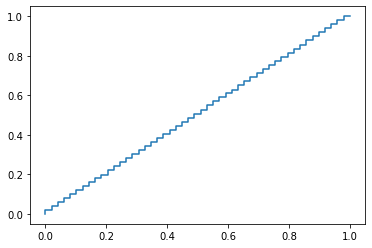

In [14]:
import statsmodels.api as sm # recommended import according to the docs


sample = np.random.uniform(0, 1, 50000)
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.step(x, y)
plt.show()

In [15]:
#Remove low variance

selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

NameError: name 'VarianceThreshold' is not defined